# Section 8: Adjusting to Shocks

## The Moving Average Model (MA)

This section, and many of the ones that will follow will be structured similarly. Just like with the AR model. 
1) We'll start by examining the **mathematical representation of the model**;
2) We'll discuss each new notation; 
3) learn how to interpret it;
4) then digest the different parts;
5) Afterwards, we'll start coding.

First we'll highlight which new packages will rely on and import them unless we've done it already. Next, we'll fit some simple version of said model to returns and analyze how well it predicts future values. We'll comment on the significance of the coefficients and the log likelihood. And then we'll extract and analyze the residuals. Once we're done, we'll try and find the appropriate number of lags we wish to include for this type of model. 

Of course, once again, we'll follow the steps from Section six to determine the best possible predictor. Earlier we mentioned the AR models usually perform poorly when predicting non stationary processes. To test if this also holds true for other types of models, we'll check how well they predict prices. Be wary that this might cause some methods to fail. So we need to proceed with caution. Now that we've set the tone for this entire section, let's start examining the moving average model.

We'll be dealing with returns in the initial part of this section. So let's suppose that R is some time series variable. Then a simple Ma model would look something like this:

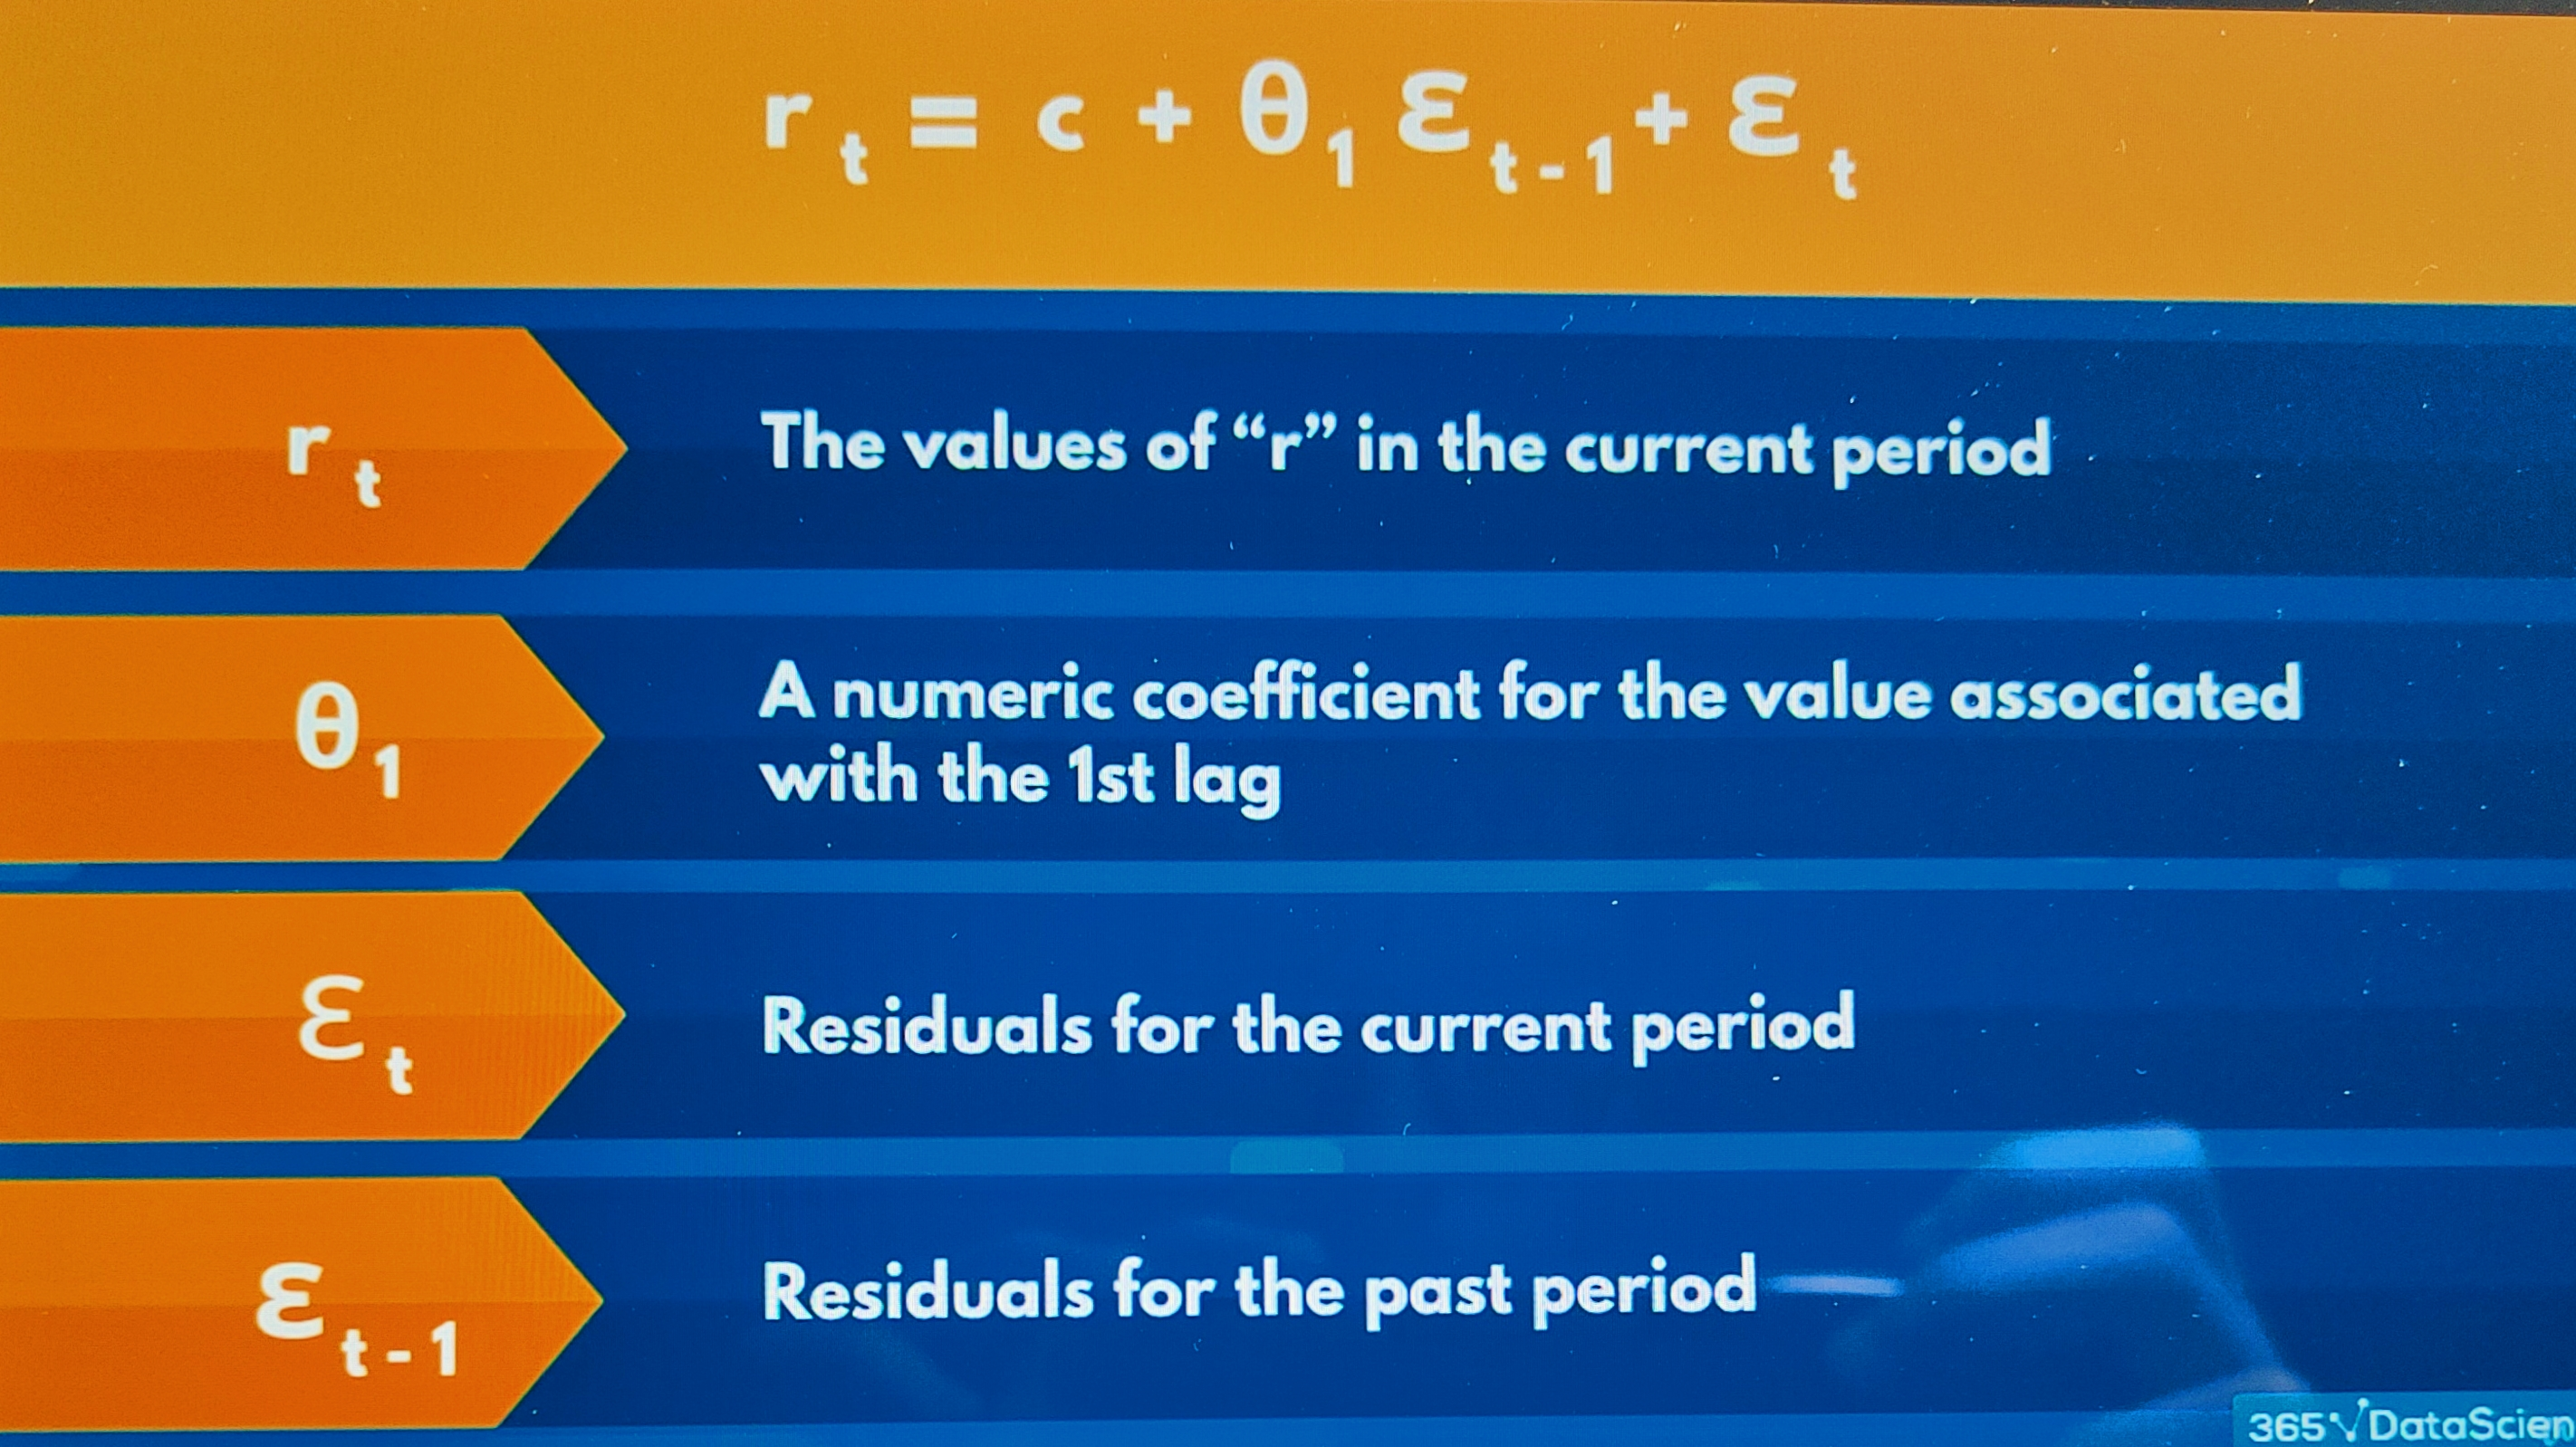

How do we generate these residuals? It's quite simple. We start from the beginning of the data set and try to predict each value depending on how far off we are each time we get a residual. Therefore, we generate these residuals as we go through the set and create the epsilon variable as we move through time. You can notice some parallels between the AR and Ma models. In fact, we can say a simple Ma model is equivalent to an infinite AR model with certain restrictions. Not to mention that an inverse relationship exists as well.

Now, in both models, we have the present day value equal, a sum of a constant, some error term and a lagged value multiplied by an assigned coefficient. **The only major difference is that the AR model uses the value of the variable, while the Ma model relies on the residual.**

Finally, there's one more common trait of the AR and Ma models. **The restriction remains that the absolute value of each coefficient should be less than one.** Once again, this is to prevent compounded effects exploding in magnitude, as we've discussed in the last section.

Apart from sharing a lot of similarities, the two types of models also have several key differences. One, such distinction between them comes in the form of determining the maximum amount of lags we are willing to include in our model. **While with the Autoregressive model, we relied on the PACF, with moving averages we rely on the ACF.** The reason is the Ma models aren't based on past period returns. Therefore, determining which lagged values have a significant direct effect on the present day ones is not relevant. Anyways, the total accumulated effects accommodate for these unexpected shocks. Hence the ACF plot provides us with information on how many lags our model should use. So to get an idea of how many lags we expect our model to include, we must compute the ACF for price returns.

## Importing the relevant packages

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()

## Importing the Data and Pre-processing 

In [33]:
raw_csv_data = pd.read_csv("Index2018.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [34]:
df_comp['market_value']=df_comp.ftse

In [35]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## The LLR Test

In [36]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

In [70]:
import warnings
warnings.filterwarnings("ignore")

## Creating Returns

In [37]:
df['returns'] = df.market_value.pct_change(1).mul(100)

/var/folders/ql/h1fp06317x57rvzq3n43d0x00000gn/T/ipykernel_31105/1399399140.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['returns'] = df.market_value.pct_change(1).mul(100)


## ACF for Returns

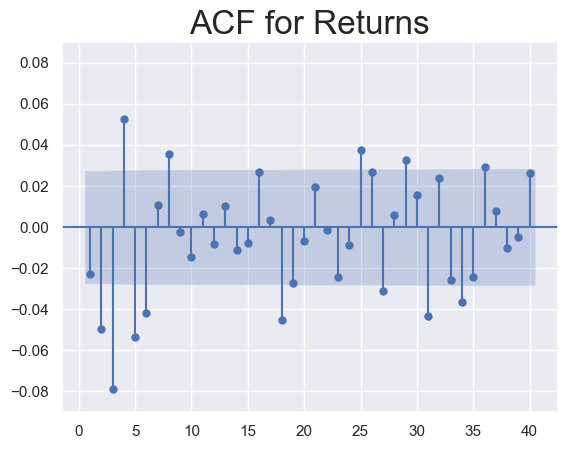

In [38]:
sgt.plot_acf(df.returns[1:], zero = False, lags = 40)
plt.title("ACF for Returns", size = 24)
plt.ylim(-0.09, 0.09)
plt.show()

## MA(1) for Returns

In [65]:
model_ret_ma_1 = ARIMA(df.returns[1:], order = (0,0,1))
results_ret_ma_1 = model_ret_ma_1.fit()
results_ret_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -7929.595
Date:                Sun, 11 Feb 2024   AIC                          15865.190
Time:                        10:37:46   BIC                          15884.754
Sample:                    01-10-1994   HQIC                         15872.045
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.146      0.252      -0.013       0.051
ma.L1         -0.0257      0.009     -3.018      0.003      -0.042      -0.009
sigma2         1.3789      0.014     99.990      0.000       1.352       1.406
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7852.85
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Higher-Lag MA Models for Returns

In [53]:
model_ret_ma_2 = ARIMA(df.returns[1:], order = (0,0,2))
results_ret_ma_2 = model_ret_ma_2.fit()
print(results_ret_ma_2.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_1, model_ret_ma_2)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -7922.864
Date:                Sun, 11 Feb 2024   AIC                          15853.728
Time:                        10:21:06   BIC                          15879.812
Sample:                    01-10-1994   HQIC                         15862.868
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.204      0.228      -0.012       0.049
ma.L1         -0.0327      0.009     -3.760      0.000      -0.050      -0.016
ma.L2         -0.0502      0.008     -6.416      0.0

In [54]:
model_ret_ma_3 = ARIMA(df.returns[1:], order = (0,0,3))
results_ret_ma_3 = model_ret_ma_3.fit()
print(results_ret_ma_3.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_2, model_ret_ma_3)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 3)   Log Likelihood               -7904.317
Date:                Sun, 11 Feb 2024   AIC                          15818.634
Time:                        10:21:28   BIC                          15851.240
Sample:                    01-10-1994   HQIC                         15830.060
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.296      0.195      -0.010       0.048
ma.L1         -0.0203      0.009     -2.334      0.020      -0.037      -0.003
ma.L2         -0.0556      0.008     -7.032      0.0

In [56]:
model_ret_ma_4 = ARIMA(df.returns[1:], order = (0,0,4))
results_ret_ma_4 = model_ret_ma_4.fit()
print(results_ret_ma_4.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_3, model_ret_ma_4)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 4)   Log Likelihood               -7898.773
Date:                Sun, 11 Feb 2024   AIC                          15809.547
Time:                        10:21:54   BIC                          15848.674
Sample:                    01-10-1994   HQIC                         15823.257
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.236      0.217      -0.011       0.049
ma.L1         -0.0203      0.009     -2.239      0.025      -0.038      -0.003
ma.L2         -0.0551      0.008     -6.835      0.0

In [57]:
model_ret_ma_5 = ARIMA(df.returns[1:], order = (0,0,5))
results_ret_ma_5 = model_ret_ma_5.fit()
print(results_ret_ma_5.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_4, model_ret_ma_5)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 5)   Log Likelihood               -7892.823
Date:                Sun, 11 Feb 2024   AIC                          15799.645
Time:                        10:22:24   BIC                          15845.294
Sample:                    01-10-1994   HQIC                         15815.641
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.282      0.200      -0.010       0.048
ma.L1         -0.0262      0.009     -2.839      0.005      -0.044      -0.008
ma.L2         -0.0497      0.008     -6.147      0.0

In [58]:
model_ret_ma_6 = ARIMA(df.returns[1:], order = (0,0,6))
results_ret_ma_6 = model_ret_ma_6.fit()
print(results_ret_ma_6.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_5, model_ret_ma_6)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 6)   Log Likelihood               -7889.221
Date:                Sun, 11 Feb 2024   AIC                          15794.442
Time:                        10:23:02   BIC                          15846.612
Sample:                    01-10-1994   HQIC                         15812.723
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.014      1.318      0.188      -0.009       0.047
ma.L1         -0.0237      0.009     -2.562      0.010      -0.042      -0.006
ma.L2         -0.0486      0.008     -5.982      0.0

In [59]:
model_ret_ma_7 = ARIMA(df.returns[1:], order = (0,0,7))
results_ret_ma_7 = model_ret_ma_7.fit()
print(results_ret_ma_7.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_6, model_ret_ma_7)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 7)   Log Likelihood               -7889.046
Date:                Sun, 11 Feb 2024   AIC                          15796.091
Time:                        10:23:20   BIC                          15854.782
Sample:                    01-10-1994   HQIC                         15816.657
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.303      0.193      -0.010       0.047
ma.L1         -0.0247      0.009     -2.645      0.008      -0.043      -0.006
ma.L2         -0.0488      0.008     -6.000      0.0

In [60]:
model_ret_ma_8 = ARIMA(df.returns[1:], order = (0,0,8))
results_ret_ma_8 = model_ret_ma_8.fit()
print(results_ret_ma_8.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_7, model_ret_ma_8)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 8)   Log Likelihood               -7885.603
Date:                Sun, 11 Feb 2024   AIC                          15791.205
Time:                        10:32:02   BIC                          15856.417
Sample:                    01-10-1994   HQIC                         15814.056
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.253      0.210      -0.011       0.048
ma.L1         -0.0238      0.009     -2.527      0.011      -0.042      -0.005
ma.L2         -0.0495      0.008     -6.053      0.0

In [61]:
LLR_test(model_ret_ma_6, model_ret_ma_8, DF=2)

0.027

## Residuals for Returns

So let's start by **extracting the eight residuals**. We do so by calling the resid attribute of the fitted model.  We want to keep the indexes intact, so we'll simply add a column to the data frame. Of course, we also need to store the results in an appropriate variable to keep in line with our elaborate naming system. We call it **res_ret_ma_8**.  

In [71]:
df['res_ret_ma_8'] = results_ret_ma_8.resid[1:]

In [72]:
df.head()

,market_value,returns,res_ret_ma_8
date,,,
1994-01-07,3445.98,NaN,NaN
1994-01-10,3440.58,-0.156704,NaN
1994-01-11,3413.77,-0.779229,-0.802107
1994-01-12,3372.02,-1.222988,-1.269464
1994-01-13,3360.01,-0.356166,-0.464783


We've recorded the residuals and we can observe their mean and variance by calling their associated functions mean and var. We really prefer easily interpretable answers so we could round the results to three decimals. And we do so by calling the round function and providing the float variable as well as how many numbers past the decimal point we want to record. To make things clearer, we can print a special message for each one. This way, we'll avoid mixing them up. Just to be on the safe side, We can transform the numeric values into text by calling the string function called STR.

In [96]:
print('The Mean of the residuals: ' + str(round(df.res_ret_ma_8.mean(),3)) + 
      '\nThe Variance of the Residuals: '+ str(round(df.res_ret_ma_8.var(),3)))

The Mean of the residuals: -0.0
The Variance of the Residuals: 1.356


Since variance is squared, standard deviation, we can use the squared root method from the math library to determine a standard deviation of 1.164. 

In [99]:
round(sqrt(df.res_ret_ma_8.var()),3)

1.164

Gaussian white noise implies normality. So we can use the 68, 95, 99 rule. This dictates what part of the data is spread within one, two and three standard deviations from the mean in either direction. Thus, we expect that most return residuals will be between -3.5 and positive 3.5. This means that worst case scenario, we could be up to seven percentage points off when predicting the returns for a market index. Of course, this is far from ideal since 7% can make all the difference when it comes to profits and losses. But before we agree that this model is not great, let's first examine its graph. Please recall from previous lectures how we use the plot method to graph time series with the date index serving as the x axis. Just as before, we also add a title and set its size. Okay. 


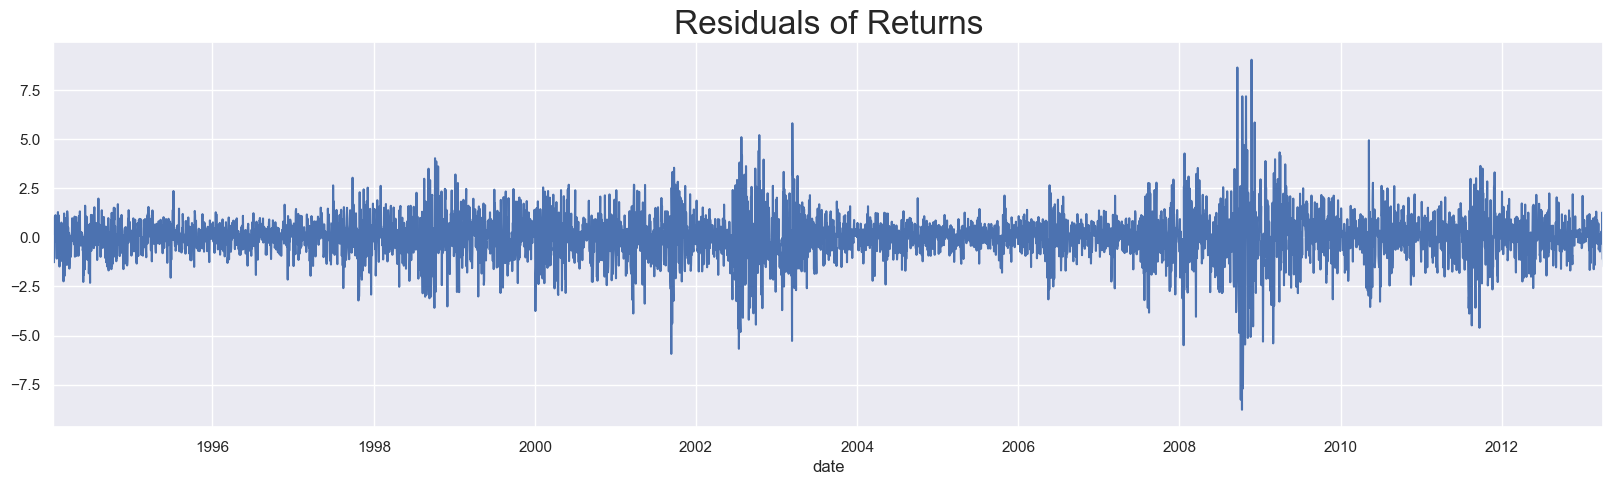

In [100]:
df.res_ret_ma_8[1:].plot(figsize = (20,5))
plt.title("Residuals of Returns", size = 24)
plt.show()

If we exclude the dotcom and housing price bubbles in the 90s and 2000 and the crisis following them, then the residuals are rather random. They're simply confined with some reasonable range which can be expected. To test if the residuals resemble a white noise process, we can check for stationarity. Of course, if the data is non stationary, it can't be considered white noise. Thus we run the adjusted dickey-fuller test.


In [101]:
sts.adfuller(df.res_ret_ma_8[2:])

(-70.83537125698383,
 0.0,
 0,
 5018,
 {'1%': -3.4316538358533277,
  '5%': -2.8621161549128313,
  '10%': -2.567076687880585},
 15684.052217389177)

We see that the P value is zero. So the set is indeed stationary. Even though we got our desired result from the test. Stationarity is not the same as white noise, so we should also examine the ACF of the residuals. In case you need a hint, a white noise process produces completely random data and all the ACF coefficients should not be significantly different from zero. 


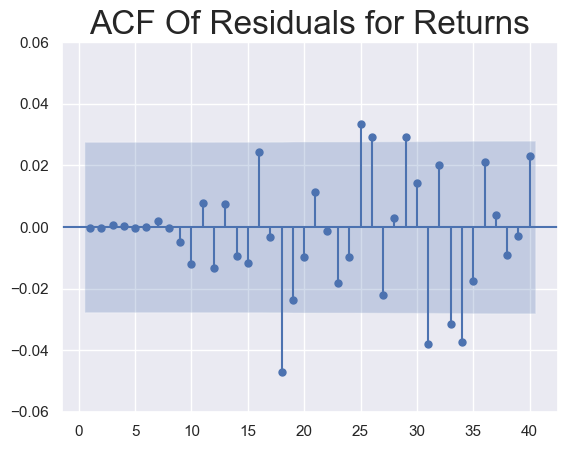

In [104]:
sgt.plot_acf(df.res_ret_ma_8[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.ylim(-0.06,0.06)
plt.show()

After running the plot ACF method, we can see that most of the coefficients are not significant. In particular, none of the first 17 lags are significant. Of course, the first eight of them are incorporated into the model, so it's not surprising they are essentially zero. However, the following nine lags are also insignificant, and this is a testament to how well our model performs. The further back in time we go, the less relevant the values and the errors become. Hence significant coefficients. Some 18 lags ago shouldn't play a major role in estimations. This stems from the fact that markets adjust to shocks so values far in the past lose relevance.

## Normalized Returns (remember we do this for the sake of comparability)

In [105]:
bench_ret = df.returns.iloc[1]
df['norm_ret'] = df.returns.div(bench_ret).mul(100)

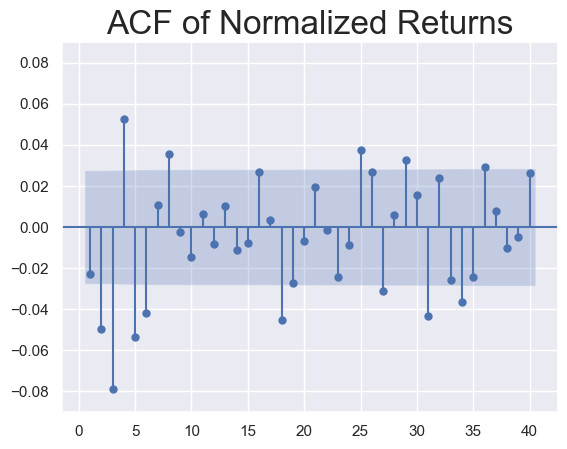

In [107]:
sgt.plot_acf(df.norm_ret[1:], zero = False, lags = 40)
plt.title("ACF of Normalized Returns",size=24)
plt.ylim(-0.09, 0.09)
plt.show()

In [109]:
model_norm_ret_ma_8 = ARIMA(df.norm_ret[1:], order=(0,0,8))
results_norm_ret_ma_8 = model_norm_ret_ma_8.fit()
results_norm_ret_ma_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                 ARIMA(0, 0, 8)   Log Likelihood              -40307.614
Date:                Sun, 11 Feb 2024   AIC                          80635.228
Time:                        11:19:55   BIC                          80700.440
Sample:                    01-10-1994   HQIC                         80658.079
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.9731      9.658     -1.240      0.215     -30.902       6.956
ma.L1         -0.0238      0.009     -2.518      0.012      -0.042      -0.005
ma.L2         -0.0495      0.008     -6.030      0.000      -0.066      -0.033
ma.L3         -0.0847      0.008    -10.271      0.000      -0.101      -0.069
ma.L4          0.0488      0.009      5.594      0.000       0.032       0.066
ma.L5         -0.0518      0.008     -6.281      0.000      -0.068      -0.036
ma.L6         -0.0402      0.009     -4.394      0.000      -0.058      -0.022
ma.L7          0.0084      0.009      0.935      0.350      -0.009       0.026
ma.L8          0.0365      0.009      3.866      0.000       0.018       0.055
sigma2      5.538e+05   6087.727     90.971      0.000    5.42e+05    5.66e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6440.41
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [110]:
df['res_norm_ret_ma_8'] = results_ret_ma_8.resid[1:]

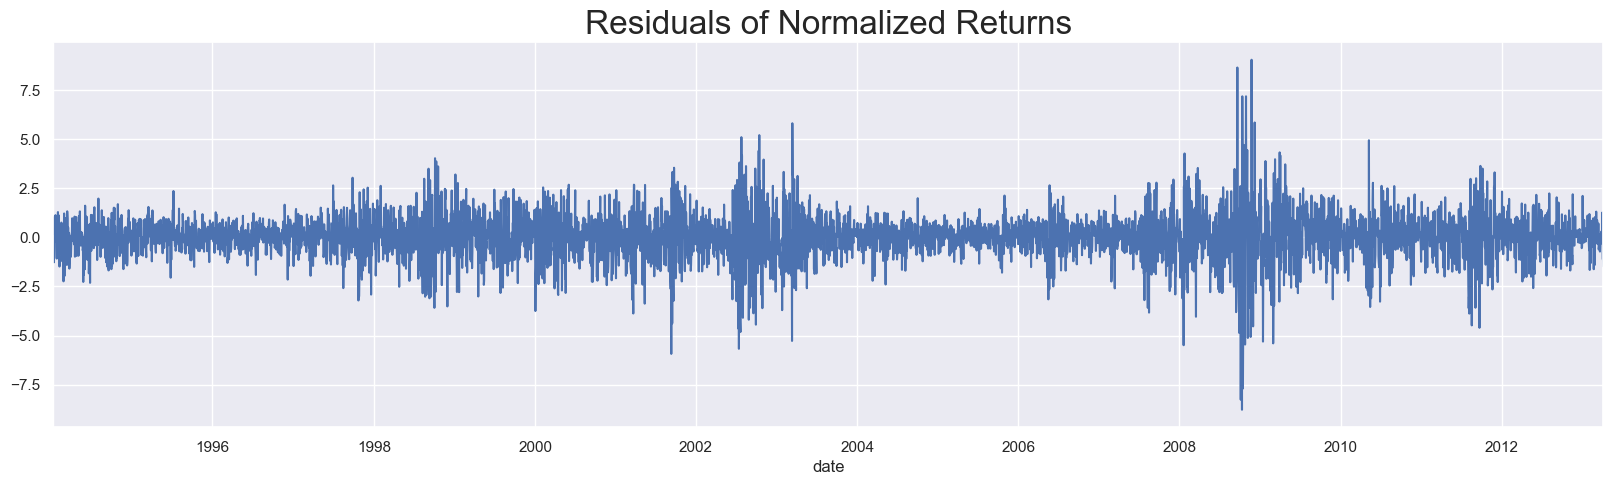

In [111]:
df.res_norm_ret_ma_8[1:].plot(figsize=(20,5))
plt.title("Residuals of Normalized Returns",size=24)
plt.show()

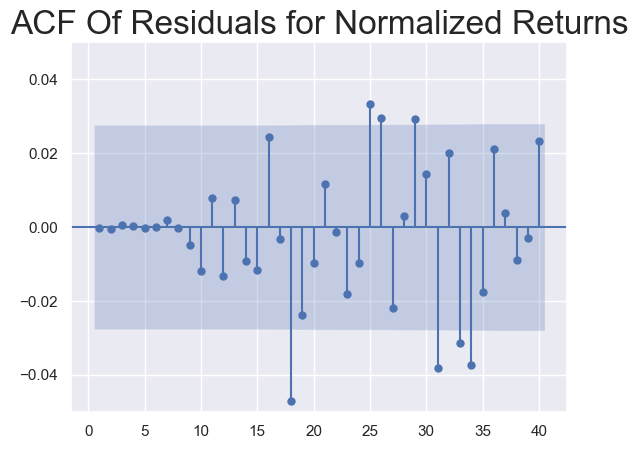

In [114]:
sgt.plot_acf(df.res_norm_ret_ma_8[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Normalized Returns",size=24)
plt.ylim(-0.05,0.05)
plt.show()

## MA Models For Prices

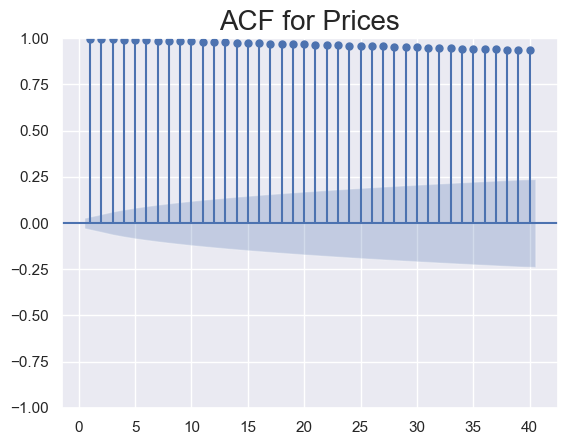

In [115]:
sgt.plot_acf(df.market_value, zero = False, lags = 40)
plt.title("ACF for Prices", size=20)
plt.show()

In [117]:
model_ma_1 = ARIMA(df.market_value, order=(0,0,1))
results_ma_1 = model_ma_1.fit()
results_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -38629.000
Date:                Sun, 11 Feb 2024   AIC                          77264.000
Time:                        11:24:48   BIC                          77283.564
Sample:                    01-07-1994   HQIC                         77270.856
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6317     15.834    321.441      0.000    5058.598    5120.665
ma.L1          0.9573      0.004    231.410      0.000       0.949       0.965
sigma2      2.817e+05   8160.557     34.519      0.000    2.66e+05    2.98e+05
===================================================================================
Ljung-Box (L1) (Q):                4221.10   Jarque-Bera (JB):               291.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""